In [1]:
# https://markov-clustering.readthedocs.io/en/latest/index.html

In [2]:
import numpy as np
import pandas as pd
import pyreadr
from itertools import combinations, chain

from dynamicTreeCut import cutreeHybrid
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

import more_itertools as mit
import random
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import show, cm, axis
import sys
import os
import re
from copy import deepcopy
import pickle
from collections import OrderedDict, Counter
np.set_printoptions(edgeitems=10, linewidth=400)

In [3]:
class MCL_Cluster(object):
    def __init__(self, merge_threshold=0.25, min_complex_size=3, max_complex_size=100, split_depth=1):
        self.merge_threshold = merge_threshold
        self.min_complex_size = min_complex_size
        self.max_complex_size = max_complex_size
        self.split_depth = split_depth
        self.break_num = 0
        self.merge_num = 0
        self.max_break_num = 0
        self.max_merge_num = 7
    
    def create_edge_adj(self, e_idx, e_w=None, dim=None, diag=None):
        self.dim = dim
        mat = np.zeros([dim, dim])
        if e_w is not None:
            if e_idx.shape[0]==2:
                mat[e_idx[0], e_idx[1]] = e_w
            elif e_idx.shape[1]==2:
                mat[e_idx[:,0], e_idx[:,1]] = e_w
            else:
                print('wrong edge dimension')
                return
        else:
            if e_idx.shape[0]==3:
                mat[e_idx[0], e_idx[1]] = e_idx[2]
            elif e_idx.shape[1]==3:
                mat[e_idx[:,0], e_idx[:,1]] = e_idx[:,2]
            elif e_idx.shape[0]==2:
                mat[e_idx[0], e_idx[1]] = 1.0
                print('Not give edge weight, use 1.0 as weight')
            elif e_idx.shape[1]==2:
                mat[e_idx[:,0], e_idx[:,1]] = 1.0
                print('Not give edge weight, use 1.0 as weight')
        mat += mat.transpose()
        if diag is not None:
            np.fill_diagonal(mat, diag)
        return mat
    
    def create_tom_adj(self, A):
        d = A.shape[0]
        L = A.dot(A.T)
        K = A.sum(axis=1)

        A_tom = np.zeros_like(A)
        for i in range(d):
            for j in range(i+1, d):  
                numerator = L[i, j] + A[i, j]
                denominator = min(K[i], K[j]) + 1 - A[i, j]
                A_tom[i, j] = numerator / denominator

        A_tom += A_tom.T
        np.fill_diagonal(A_tom, 0)
        return np.nan_to_num(A_tom)
    
    def iterate(self, A, expand_power, inflate_power):
        A_ = np.linalg.matrix_power(A, expand_power)  # expand
        A_ = np.power(A_, inflate_power)              # inflate
        A_ = A_ / A_.sum(0)                           # col-wise normalization
        AA = A_.copy()
        A_[A_ < 0.001] = 0                            # pruning
        num_cols = AA.shape[1]
        col_indices = np.arange(num_cols)
        row_indices = A.argmax(axis=0).reshape((num_cols,)) # keep max of each col in original matrix
        A_[row_indices, col_indices] = AA[row_indices, col_indices]
        return A_
    
    def MCL_process(self, A, expand_power=2, inflate_power=2, iters=2):
        A_ = A / A.sum(0)
        for j in range(iters):
            A_ = self.iterate(A_, expand_power, inflate_power)
        np.fill_diagonal(A_, 0)
        return A_
    
    def label_nodes(self, n_idx, lab):
        # https://stackoverflow.com/questions/39387435/group-list-elements-based-on-another-list
        sidx = lab.argsort()                                    # Get sidx (sorted indices) for label
        split_idx = np.flatnonzero(np.diff(lab[sidx]) > 0) + 1  # Get where the sorted version of label changes groups
        groups = np.split(n_idx[sidx], split_idx)               # Sort input based on the sidx and split label on split_idx
        return [tuple(sorted(i)) for i in groups]
    
    def remove_subset(self, Cs):
        return list(filter(lambda f: not any(set(f) < set(g) for g in Cs), Cs))
    
    def get_modularity(self, A, Cs, gamma=1.0):
        Lc_m = [( np.array(list(combinations(Cs[j], 2))).shape[0]  / ((np.array(A.nonzero()).T.shape[0] - A.shape[0])/2) ) for j in range(len(Cs))]
        kc_2m = [(( sum([A[k, :].sum() for k in Cs[j]]) / (np.array(A.nonzero()).T.shape[0] - A.shape[0]) )**2)*gamma for j in range(len(Cs))]
        M = np.array(Lc_m)-np.array(kc_2m)
        return M
    
    def extract_clusters(self, A, keep_idx=None):
        print('extract clusters')
        
        zero_idx = np.array(list(set(np.where(A.sum(0)!=0)[0])&set(np.where(A.sum(1)!=0)[0])))
        
        I = self.create_tom_adj(np.power(A, 2.5))
        
        if keep_idx is None:
            keep_idx = zero_idx
        else:
            keep_idx = np.array(list( set(keep_idx) & set(zero_idx) ))
        
        A_ = A[keep_idx, :][:, keep_idx]
        A_ = self.MCL_process(A_, iters=3)
        I_ = I[keep_idx, :][:, keep_idx]
        
        imp_1 = A_*0.3 + I_*0.7
        imp_2 = A_*0.1 + I_*0.9
        
        dist_1 = pdist(imp_1, metric='cosine')
        dist_2 = pdist(imp_2, metric='cosine')
        
        dist_1[~np.isfinite(dist_1)] = 1.0
        dist_2[~np.isfinite(dist_2)] = 1.0
        
        link_1 = linkage(dist_1, 'ward')
        link_2 = linkage(dist_2, 'ward')
        
        Cs_lab_1 = cutreeHybrid(link_1, dist_1, minClusterSize=(self.min_complex_size), deepSplit=self.split_depth, respectSmallClusters=True, verbose=False, pamStage=True)
        Cs_lab_2 = cutreeHybrid(link_2, dist_2, minClusterSize=(self.min_complex_size), deepSplit=self.split_depth, respectSmallClusters=True, verbose=False, pamStage=True)
        Cs_lab_1 = Cs_lab_1['labels']
        Cs_lab_2 = Cs_lab_2['labels']
        
        Cs_1 = self.label_nodes(keep_idx, Cs_lab_1)
        Cs_2 = self.label_nodes(keep_idx, Cs_lab_2)
        Cs = Cs_1 + Cs_2
        
        # m = self.get_modularity(I, Cs, gamma=10)
        # Cs_ = [Cs[j] for j in np.where(m <= 0.00)[0]]
        # Cs = [Cs[j] for j in np.where(m > 0.00)[0]]
        
        # small_Cs = [j for j in Cs if (len(j) >= self.min_complex_size)&(len(j) <= self.max_complex_size)] + [j for j in Cs_ if (len(j) >= self.min_complex_size)&(len(j) <= self.max_complex_size)]
        small_Cs = [j for j in Cs if (len(j) >= self.min_complex_size)&(len(j) <= self.max_complex_size)]
        large_Cs = [j for j in Cs if len(j) > self.max_complex_size]
        
        while len(large_Cs) > 0 and self.break_num <= self.max_break_num:
            print('break clusters, break iter: ', self.break_num)
            
            idx = 0
            max_idx = len(large_Cs)
            max_idx_ori = len(large_Cs)
            while (idx < max_idx)&(idx < max_idx_ori):
                cur_large_C = large_Cs[idx]
                
                keep_idx = np.array(list( set(cur_large_C) & set(zero_idx) ))
                # keep_idx = np.array(list( set(chain.from_iterable([j for j in cur_large_C])) & set(zero_idx) ))
                
                A_ = A[keep_idx, :][:, keep_idx]
                A_ = self.MCL_process(A_, iters=5)
                I_ = I[keep_idx, :][:, keep_idx]
                
                imp_1 = A_*0.3 + I_*0.7
                imp_2 = A_*0.1 + I_*0.9

                dist_1 = pdist(imp_1, metric='cosine')
                dist_2 = pdist(imp_2, metric='cosine')

                dist_1[~np.isfinite(dist_1)] = 1.0
                dist_2[~np.isfinite(dist_2)] = 1.0

                link_1 = linkage(dist_1, 'ward')
                link_2 = linkage(dist_2, 'ward')

                Cs_lab_1 = cutreeHybrid(link_1, dist_1, minClusterSize=(self.min_complex_size), deepSplit=self.split_depth, respectSmallClusters=True, verbose=False, pamStage=True)
                Cs_lab_2 = cutreeHybrid(link_2, dist_2, minClusterSize=(self.min_complex_size), deepSplit=self.split_depth, respectSmallClusters=True, verbose=False, pamStage=True)
                Cs_lab_1 = Cs_lab_1['labels']
                Cs_lab_2 = Cs_lab_2['labels']

                Cs_1 = self.label_nodes(keep_idx, Cs_lab_1)
                Cs_2 = self.label_nodes(keep_idx, Cs_lab_2)
                Cs = Cs_1 + Cs_2
                
                small_Cs = small_Cs + [j for j in Cs if (len(j) >= self.min_complex_size)&(len(j) <= self.max_complex_size)]
                large_Cs = large_Cs + [j for j in Cs if len(j) > self.max_complex_size]
                large_Cs = self.remove_subset(large_Cs)
                idx += 1
                max_idx = len(large_Cs)
            self.break_num += 1
        self.break_num = 0
        # small_Cs = self.remove_subset(small_Cs)
        return small_Cs
    
    def get_ove_score(self, list1, list2):
        if type(list1[0])!=list and type(list1[0])!=tuple:
            list1 = [list1]
        if type(list2[0])!=list and type(list2[0])!=tuple:
            list2 = [list2]
        
        s1 = np.array([[len(set(list1[k])&set(tuple(j)))**2 for j in list2 ] for k in range(len(list1))])
        s2 = np.array([[len(list1[k])*len(j) for j in list2 ] for k in range(len(list1))])
        ove_score = np.nan_to_num(s1 / s2)
        if ove_score.shape[0] > 1:
            np.fill_diagonal(ove_score, 0)
            return ove_score
        else:
            return ove_score.reshape(-1)
    
    def merge_clusters(self, Cs, A):
        if_merge = True
        while if_merge:
            print('merge clusters, merge iter: ', self.merge_num)
            ove_score = self.get_ove_score(Cs, Cs)
            ove_score = np.triu(ove_score, k=1) # keep only upper traingular values
            
            ## Combind cluster id with their overlap score
            ove_clusters_pair_id_w = list(zip(zip(np.arange(ove_score.shape[0]), ove_score.argmax(1)), ove_score.max(1))) # [(cluster_id1, cluster_id2), ove_score]
            ove_clusters_pair_id_w = [j for j in ove_clusters_pair_id_w if j[1] >= self.merge_threshold]                  # keep those with overlap score >= threshold
            
            if len(ove_clusters_pair_id_w) < 1:
                if_merge = False
            else:
                ## Index of clusters with similarity highr than a threshold
                ove_clusters_id = list(set([j for k in [i[0] for i in ove_clusters_pair_id_w] for j in k]))
                
                ## Sorted by overlap score
                ove_clusters_pair_id_w = sorted(ove_clusters_pair_id_w, key=lambda x: x[1], reverse=True)
                
                ## Combind cluster id, overlap score, and overlap size
                ove_clusters_pair_id_w_size = [ove_clusters_pair_id_w[idx] + 
                                               ( len(set(Cs[ove_clusters_pair_id_w[idx][0][0]] + 
                                                         Cs[ove_clusters_pair_id_w[idx][0][1]])), ) 
                                               for idx in range(len(ove_clusters_pair_id_w))] # [(cluster_id1, cluster_id2), ove_score, ove_size]
                
                ## filter by max size
                ove_clusters_pair_id_w_size = [j for j in ove_clusters_pair_id_w_size if j[2] <= self.max_complex_size]
                
                if len(ove_clusters_pair_id_w_size) < 1:
                    if_merge = False
                else:
                    ## combind pairs to set
                    ove_clusters_pair_id_w_size_set = [[j for j in ove_clusters_pair_id_w_size if k in j[0]] for k in ove_clusters_id]
                    ove_clusters_pair_id_w_size_set = [j for j in ove_clusters_pair_id_w_size_set if len(j) > 0]
                    
                    if len(ove_clusters_pair_id_w_size_set) < 1:
                        if_merge = False
                    else:
                        ## Collect all the id of clusters that need to merge
                        ove_clusters_id_set = list(set( [tuple(sorted( set(chain.from_iterable( [j[0] for j in ove_clusters_pair_id_w_size_set[k]] )) )) 
                                                         for k in range(len(ove_clusters_pair_id_w_size_set))] ))
                        
                        ## Remove subset
                        ove_clusters_id_set_sub = self.remove_subset(ove_clusters_id_set)
                        
                        ## Index of clusters that will be merged / not be merged
                        ove_clusters_id = list(set([k for j in ove_clusters_id_set_sub for k in j]))
                        non_ove_clusters_id = list(set(range(len(Cs)))^set(ove_clusters_id))
                        
                        Cs = [tuple(sorted( set(chain.from_iterable([Cs[j] for j in ove_clusters_id_set_sub[k]])) )) 
                              for k in range(len(ove_clusters_id_set_sub))] + [Cs[j] for j in non_ove_clusters_id]
                        
                        small_Cs = [j for j in Cs if (len(j) >= self.min_complex_size)&(len(j) <= self.max_complex_size)]
                        large_Cs = [j for j in Cs if len(j) > self.max_complex_size]
                        
                        if len(large_Cs) > 0 and self.merge_num <= self.max_merge_num:
                            keep_idx = np.array(list(set(chain.from_iterable([j for j in large_Cs]))))
                            small_Cs = small_Cs + self.extract_clusters(A, keep_idx=keep_idx)
                            small_Cs = self.remove_subset(small_Cs)
                        else:
                            if_merge = False
                        
                        Cs = small_Cs
                        self.merge_num += 1
        
        self.merge_num = 0
        return Cs
    
    def run(self, e_idx, e_w=None, dim=None, diag=None):
        if dim is None:
            print('Dim must specified')
            return
        else:
            A = self.create_edge_adj(e_idx, e_w=e_w, dim=dim, diag=diag)
            Cs = self.extract_clusters(A)
            Cs = self.merge_clusters(Cs, A)
            Cs = self.remove_subset(Cs)
            Cs = list(set(Cs))
            return Cs

## Read data

In [ ]:
#### Setting
exp_name = 'PXD002892'

exp_path = ['./output/' + i for i in os.listdir('./output/')]
exp_path = [i for i in exp_path if ('all_emb' not in i)&('checkpoint' not in i)]
print(*exp_path, sep='\n')
exp_cond = sorted(set([i.split('/')[-1].split('_')[0] for i in exp_path]))
print(exp_cond)

load_dir1 = 'path to input' + '/' + exp_name
dict_path = ['/'.join([load_dir1, i]) for i in os.listdir(load_dir1) if 'idx_dict' in i]
dict_path = [i for i in dict_path if 'SEC2' in i]
dict_path = [i for i in dict_path if (re.sub('.pickle', '', i.split('/')[-1].split('_')[-1]) in exp_cond)]
print(*dict_path, sep='\n')

load_dir2 = 'path to Split-data' + exp_name
split_path = [load_dir2 + '/' + i for i in os.listdir(load_dir2) if ('ref' in i) or ('heldout' in i) or ('exp' in i)]
split_path = [i for i in split_path if (re.sub('.rds', '', i.split('/')[-1].split('_')[-1]) in exp_cond)]
print(*split_path, sep='\n')

load_dir3 = 'path to Protein complex-data'
print(load_dir3)

### Gold standard

In [19]:
gs = list(pyreadr.read_r(load_dir3 + '/Complexes_gene_Human_filter.rds').values())[0]
gs

,ComplexName,UniProt_entry,Gene_name,Gene_name_primary,Gene_entrez,UniProt_entry_N,Gene_name_N,Gene_name_primary_N
0,Nuclear pore complex,Q9NRG9,AAAS,AAAS,None,31,31,31
1,AATF-NGDN-NOL10 complex,Q9NY61,AATF,AATF,26574,3,3,3
2,ABCB1-PPP2R3C-TFPI2 complex,P08183,ABCB1,ABCB1,5243,3,3,3
3,ABCB1-ANXA2-RACK1-SRC complex,P08183,ABCB1,ABCB1,5243,4,4,4
4,SNW1 complex,Q9UG63,ABCF2,ABCF2,10061,18,18,18
...,...,...,...,...,...,...,...,...
12686,EMX1-GLI3-WDR11 complex,Q8WWQ0,WDR11,PHIP,55717,4,3,3
12687,CEN complex,Q8WWQ0,WDR11,PHIP,55717,38,37,38
12688,TNFR2 signaling complex,Q9NQH7,XPNPEP3,XPNPEP3,None,4,3,3
12689,AIM2 PANoptosome complex,Q9NZI8,ZBP1,IGF2BP1,81030,10,9,10


In [20]:
gs = list(gs.groupby('ComplexName')['Gene_name'].apply(list).values)
print(len(gs))
print(*gs[:5], sep='\n')

2277
['SNRPE', 'SNRPF', 'SNRPG']
['PDCD7', 'PRKRIP1', 'SNRNP25', 'SNRNP35', 'SNRNP48', 'SNRPB', 'SNRPD1', 'SNRPD2', 'SNRPD3', 'SNRPE', 'SNRPF', 'SNRPG', 'SRSF7', 'TOE1', 'YBX1', 'SNRPD1', 'SNRPD1']
['MAPT', 'SGK1', 'YWHAQ']
['CHERP', 'DDX46', 'DHX15', 'DNAJC8', 'HMG20B', 'HSPD1', 'PHF5A', 'PUF60', 'RBM17', 'SF3A1', 'SF3A2', 'SF3A3', 'SF3B1', 'SF3B2', 'SF3B3', 'SF3B4', 'SF3B5', 'SF3B6', 'SMNDC1', 'SNRPA1', 'SNRPB', 'SNRPB2', 'SNRPD1', 'SNRPD2', 'SNRPD3', 'SNRPE', 'SNRPF', 'SNRPG', 'SRSF1', 'TRAP1', 'U2AF1', 'U2AF2', 'U2SURP', 'SNRPD1', 'TRAP1', 'SNRPD1', 'TRAP1']
['DHX15', 'PDCD7', 'PRPF8', 'RNPC3', 'SF3B1', 'SF3B2', 'SF3B3', 'SF3B4', 'SF3B5', 'SF3B6', 'SNRNP25', 'SNRNP35', 'SNRNP48', 'SNRPB', 'SNRPD1', 'SNRPD2', 'SNRPD3', 'SNRPE', 'SNRPF', 'SNRPG', 'YBX1', 'ZCRB1', 'ZMAT5', 'ZRSR2', 'SNRPD1', 'SNRPD1']


In [21]:
name_idx_dict = []
for cur_dict_path in dict_path:
    with open(cur_dict_path, 'rb') as f:
        temp = pickle.load(f)
    name_idx_dict.append(temp)
print(len(name_idx_dict))
print([len(name_idx_dict[i]) for i in range(len(name_idx_dict))])

1
[4002]


In [22]:
### filter gs by exp name
gs_sub = [[[i for i in gs[j] if i in name_idx_dict[k].keys()] for j in range(len(gs))] for k in range(len(name_idx_dict))]
print(len(gs_sub))
print([len(gs_sub[i]) for i in range(len(gs_sub))])

1
[2277]


In [23]:
### match name by idx
complexes = [[tuple([name_idx_dict[k][i] for i in gs_sub[k][j]]) for j in range(len(gs_sub[k]))] for k in range(len(name_idx_dict))]
print(len(complexes))
print([len(complexes[i]) for i in range(len(complexes))])
print(*complexes[0][:5], sep='\n')

1
[2277]
(1437, 1438, 1439)
(1433, 1434, 1435, 1436, 1437, 1438, 1439, 1467, 1554, 1688, 1434, 1434)
(742, 1695)
(218, 332, 339, 565, 602, 1030, 1182, 1225, 1383, 1384, 1385, 1386, 1387, 1388, 1423, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1460, 1568, 1607, 1608, 1609, 1434, 1568, 1434, 1568)
(339, 1132, 1385, 1386, 1387, 1388, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1688, 1434, 1434)


In [24]:
### filter by complex size
complexes = [[i for i in complexes[j] if len(i) > 2] for j in range(len(complexes))]
print(len(complexes))
print([len(complexes[i]) for i in range(len(complexes))])
print(*complexes[0][:5], sep='\n')

1
[941]
(1437, 1438, 1439)
(1433, 1434, 1435, 1436, 1437, 1438, 1439, 1467, 1554, 1688, 1434, 1434)
(218, 332, 339, 565, 602, 1030, 1182, 1225, 1383, 1384, 1385, 1386, 1387, 1388, 1423, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1460, 1568, 1607, 1608, 1609, 1434, 1568, 1434, 1568)
(339, 1132, 1385, 1386, 1387, 1388, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1688, 1434, 1434)
(233, 1123, 1433, 1434, 1435, 1436, 1434, 1434)


### Prediction

In [30]:
edges = deepcopy(exp_cond)
w = deepcopy(exp_cond)
n_nodes = deepcopy(exp_cond)
for l in range(len(exp_cond)):
    cur_split_path = [split_path[j] for j in [i for i, v in enumerate(split_path) if exp_cond[l] in v]]
    cur_df = list(pyreadr.read_r([i for i in cur_split_path if 'ref' in i][0]).values())[0]
    cur_df = pd.concat([cur_df, list(pyreadr.read_r([i for i in cur_split_path if 'heldout' in i][0]).values())[0]], ignore_index=True, sort=False)
    cur_df = pd.concat([cur_df, list(pyreadr.read_r([i for i in cur_split_path if 'exp' in i][0]).values())[0]], ignore_index=True, sort=False)

    cur_cv_path = [i for i in exp_path if exp_cond[l] in i]
    
    cur_df['cv1'] = np.concatenate([np.load([i for i in cur_cv_path if ('train' in i)][0])['arr_0'], 
                                    np.load([i for i in cur_cv_path if ('heldout' in i)][0])['arr_0'], 
                                    np.load([i for i in cur_cv_path if ('delfold' in i)][0])['arr_0'],
                                    np.load([i for i in cur_cv_path if ('exp' in i)][0])['arr_0']], 0)

    cur_edge = cur_df.iloc[:, 0:2].values
    cur_label = np.mean(cur_df.loc[:, [col for col in cur_df.columns if 'cv' in col]].values, 1)
    cur_edge = np.array(list(zip([name_idx_dict[l][i] for i in cur_edge[:, 0]], [name_idx_dict[l][i] for i in cur_edge[:, 1]])))
    
    edges[l] = cur_edge
    w[l] = cur_label 
    n_nodes[l] = list(pyreadr.read_r( '/'.join(['path to EPF-data', epx_name, exp_cond[l]+'.rds']) ).values())[0].shape[0]

## Cluster

extract clusters
..cutHeight not given, setting it to 18.43027583126573  ===>  99% of the (truncated) height range in dendro.
..cutHeight not given, setting it to 18.42918914652604  ===>  99% of the (truncated) height range in dendro.
break clusters, break iter:  0
..cutHeight not given, setting it to 0.6323751461903582  ===>  99% of the (truncated) height range in dendro.
..cutHeight not given, setting it to 0.6324066455765278  ===>  99% of the (truncated) height range in dendro.
..cutHeight not given, setting it to 0.9559233199587112  ===>  99% of the (truncated) height range in dendro.
..cutHeight not given, setting it to 0.9560512508285544  ===>  99% of the (truncated) height range in dendro.
..cutHeight not given, setting it to 0.7274468547297068  ===>  99% of the (truncated) height range in dendro.
..cutHeight not given, setting it to 0.7276258147156645  ===>  99% of the (truncated) height range in dendro.
..cutHeight not given, setting it to 0.6482487522355823  ===>  99% of the 

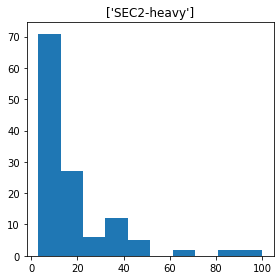

In [33]:
N = 1
clusters = deepcopy(n_nodes)
overlap_score = deepcopy(n_nodes)
best_matched_cluster_info = deepcopy(n_nodes)
best_matched_complex_info = deepcopy(n_nodes)
cluster_cluster_score = deepcopy(n_nodes)

for l in range(len(exp_cond)):
    mcl = MCL_Cluster(merge_threshold=0.25, min_complex_size=3, max_complex_size=100, split_depth=3)
    cur_cluster = mcl.run(edges[l], e_w=w[l], dim=n_nodes[l], diag=1.0)
    cur_overlap_score = mcl.get_ove_score(cur_cluster, complexes[l])

    cur_best_matched_cluster = cur_overlap_score.argmax(0) # best matched cluster for each complex
    cur_best_matched_complex = cur_overlap_score.argmax(1) # best matched complex for each cluster
    cur_best_matched_cluster_score = cur_overlap_score.max(0) # overlap perc between best matched cluster and each complex
    cur_best_matched_complex_score = cur_overlap_score.max(1) # overlap perc between best matched complex and each cluster

    cur_best_matched_cluster_info = [tuple([i, cur_best_matched_cluster[i], 
                                            cur_best_matched_cluster_score[i]]) for i in range(len(cur_best_matched_cluster))] # 0:complex id, 1:best cluster id, 2:overlap perc
    cur_best_matched_complex_info = [tuple([i, cur_best_matched_complex[i], 
                                            cur_best_matched_complex_score[i]]) for i in range(len(cur_best_matched_complex))] # 0:cluster id, 1:best complex id, 2:overlap perc
    cur_best_matched_cluster_info = sorted(cur_best_matched_cluster_info, key=lambda x: x[2], reverse=True)
    cur_best_matched_complex_info = sorted(cur_best_matched_complex_info, key=lambda x: x[2], reverse=True)

    cur_cluster_cluster_score = mcl.get_ove_score(cur_cluster, cur_cluster)

    clusters[l] = cur_cluster
    overlap_score[l] = cur_overlap_score
    best_matched_cluster_info[l] = cur_best_matched_cluster_info
    best_matched_complex_info[l] = cur_best_matched_complex_info
    cluster_cluster_score[l] = cur_cluster_cluster_score

    print(exp_name + ' ' + exp_cond[l])
    print(len(cur_cluster), min([len(i) for i in cur_cluster]), max([len(i) for i in cur_cluster]))

f, a = plt.subplots(1, 1, figsize=(4,4))
a.hist([len(i) for i in clusters[0]])
a.set_title(datas[0])
plt.tight_layout()

## Save output

In [38]:
out_path = './analysis'
if not os.path.exists(out_path):
      os.makedirs(out_path)

out_path = './analysis/Cluster'
if not os.path.exists(out_path):
      os.makedirs(out_path)

In [39]:
#### Save clusters
for l in range(len(exp_cond)):
    with open('./analysis/Cluster/' + '_'.join([exp_cond[l], 'clusters.txt']), 'w') as output:
        for line in clusters[l]:
            s = " ".join(map(str, line))
            output.write(s+'\n')

In [40]:
#### Save cluster info
for l in range(len(exp_cond)):
    np.save('./analysis/Cluster/' + '_'.join([exp_cond[l], 'overlap_score.npy']), overlap_score)
    np.save('./analysis/Cluster/' + '_'.join([exp_cond[l], 'best_matched_cluster_info.npy']), best_matched_cluster_info)
    np.save('./analysis/Cluster/' + '_'.join([exp_cond[l], 'best_matched_complex_info.npy']), best_matched_complex_info)
    np.save('./analysis/Cluster/' + '_'.join([exp_cond[l], 'cluster_cluster_score.npy']), cluster_cluster_score)

## Load ouput

In [41]:
with open('./analysis/Cluster/' + '_'.join([exp_cond[0], 'clusters.txt']),'r') as fh:
    a = []
    for oneline in fh:
        oneline = oneline.strip()
        a.append(oneline)
print(len(a))
print(*a[:5], sep='\n')
print('*'*50)
print(len(clusters[0]))
print(*clusters[0][:5], sep='\n')

127
115 231 357 482 509 611 692 693 700 728
880 896 897
30 63 95 168 170 181 201 219 248 419 431 464 476 514 515 518 531 536 546 600 610 612 636 697 705 714 724 790 884 933 975 1007 1115 1215 1217 1368 1391 1425 1480 1485 1493 1495 1499 1550 1616 1640 1659 1660 1697 1715 1722 1744 1752 1763 1767 1778 1823 1843 1855 1858 1859 1867 1870 1887 1897 1984 2058 2144 2181 2228 2255 2288 2311 2315 2319 2320 2323 2340 2351 2390 2392 2393 2409 2419 2429 2469 2565 2710 2830 2842 3071 3189 3229 3342 3624 3740 3751 3753 3754 3952
356 434 470 499 601
953 1544 1757 1879 1896 1910 1912 1913 1923 2077 2082 2112 2204 2260 2458 2460 2567 2568 2653 2657 2696 2831 2960 2994 3191 3243 3278 3280 3317 3318 3319 3325 3348 3433 3461 3471 3514 3586 3633 3634 3728 3762 3785 3873 3893 3951 3962
**************************************************
127
(115, 231, 357, 482, 509, 611, 692, 693, 700, 728)
(880, 896, 897)
(30, 63, 95, 168, 170, 181, 201, 219, 248, 419, 431, 464, 476, 514, 515, 518, 531, 536, 546, 600, 610,